In [1]:
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg

##  Первое задание. Предобусловленный метод сопряженных градиентов.

Задача, решить линейную систему:
$$
Ax = b
$$

Где $A$ -  матрица оператора Лапласа, $b$ константный вектор.



$$
\begin{equation}
A =  \frac{1}{h^2}
\begin{pmatrix}
2 & -1 & \cdots & 0 &0 \\
-1 & 2 & \cdots & 0 & 0\\
\vdots  & \vdots  & \ddots & \vdots & \vdots \\
0 & 0& \cdots &-2 & 1 \\
0 & 0& \cdots &-1 & 1
\end{pmatrix}
\label{eq::Amat}
\end{equation}
$$

$h$ - Шаг сетки. Пусть сетка равномерная, тогда $h=\frac{1}{n+1}$, где $n+1$ - количество узлов в сетке. 


Задать такую матрицу и вектор можно следкющим образом 

In [2]:
#n можно взять любым больше 100. Перевести разрженную матрицу в плотную можно мотодом toarray()
np.random.seed(23)

n = 1000
A =  sp.diags([-1, 2, -1], [-1,0,1], shape = (n, n)) 
A =  A *(n+1)**2

#константный вектор правой части
b =  np.ones(n) * 6.

# рандомная начальная точка
x0 = np.random.rand(n)



Число обусловленности такой матрицы будет большим

In [3]:
w, _= np.linalg.eig(A.toarray())
np.linalg.cond(A.toarray()), max(w)/min(w)

(406095.04265001946, 406095.0426335769)

In [4]:
np.isclose(max(w)/min(w), np.linalg.cond(A.toarray()))

True

Проверить, как отработает метод сопряженных градиентов на такой задаче. (Метод можно взять из семинара)

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 


![](PCG.png)

([Полный текст тут](http://www.cse.psu.edu/~b58/cse456/lecture20.pdf))

Написать метод сопряженных градиентов, учитывая действие предобуславлевателя. 

In [5]:
def ConjugateGradient(x0, A, b, tol=1e-8, callback=None):
    x = x0
    r = b - A.dot(x0) 
    p = r
    while np.linalg.norm(r) > tol:
        
        alpha = r.dot(r) / p.dot(A.dot(p))
        x = x + alpha * p
        r_next = r - alpha * A.dot(p)
        beta = r_next.dot(r_next) / r.dot(r)
        p = r_next + beta * p
        r = r_next

        if callback is not None:
            callback(x)
    return x

def PreconditionedCG(x0, A, b, M, tol=1e-8, callback=None):
    x = x0
    r_prev = b - A.dot(x0) 
    z_prev = sp.linalg.spsolve(M, r_prev)
    
    p = z_prev
    w = A.dot(p)
    alpha = r_prev.dot(z_prev) / p.dot(w)
    x = x0 + alpha * p
    r_cur = r_prev - alpha * w
    
    while np.linalg.norm(r_cur) > tol:
        z_cur = sp.linalg.spsolve(M, r_cur)
        beta = r_cur.dot(z_cur) / r_prev.dot(z_prev)
        p = z_cur + beta * p
        w = A.dot(p)
        alpha = r_cur.dot(z_cur) / p.dot(w)
        x = x + alpha * p
        r_prev, r_cur = r_cur, r_cur - alpha * w
        z_prev = z_cur
        if callback is not None:
            callback(x)
        
    return x

Проверить работу метода на предобуславлевателе Гаусса-Зейделя. Обратите внимание, что есть симметричный и не симметричные варианты. Какой надо взять?([Статья с предобуславлевателями для метода сопряжённых градиентов](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.592.1575&rep=rep1&type=pdf))

In [6]:
D = sp.diags(A.diagonal())
D_inv = sp.diags(1 / A.diagonal())
L = sp.tril(A)
U = sp.triu(A)

M = (D + L) @ D_inv @ (D + U)

Сравните результат работы предобусловленной и непредобусловленной версии

In [7]:
iters = []
call = lambda x : iters.append(x)


kek = ConjugateGradient(x0, A, b, callback=call)
cg_iters = len(iters)

iters = []
lol = PreconditionedCG(x0, A, b, M, callback=call)
pcg_iters = len(iters)

print("ConjugateGradient steps: {}".format(cg_iters))
print("PreconditionedCG steps: {}".format(pcg_iters))

ConjugateGradient steps: 1001
PreconditionedCG steps: 641


Второй метод имеет скорость сходимости, практически в 2 раза большую, чем первый метод.

## Второе задание. Метод момента

Реализовать Метод момента.

![](Momentum.png)

([Картинка отсюда](https://cs231n.github.io/neural-networks-3/))

Сравнить его с методом Нестерова и методом градиентного спуска, которые были преддставлены на семинаре. Сравнивать можно на $2D$  задаче с семинара

In [8]:
import types
def backtracking (x, f, grad_f, rho, alpha0, beta1, beta2):
    
    alpha = alpha0
    if isinstance(grad_f ,types.FunctionType):
        phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
        phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
        f_k = f(x - alpha * grad_f(x)) 
    else:
        phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
        phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
        f_k = f(x - alpha * grad_f) 

    while not ((f_k <=phi1) and 
              (f_k >=phi2)):
        alpha *= rho
        
        if isinstance(grad_f ,types.FunctionType):
            phi1 = f(x) -  beta1 * alpha * grad_f(x).dot(grad_f(x))
            phi2 = f(x) -  beta2 * alpha * grad_f(x).dot(grad_f(x))    
            f_k = f(x - alpha * grad_f(x)) 
        else: 
            phi1 = f(x) -  beta1 * alpha * grad_f @ grad_f
            phi2 = f(x) -  beta2 * alpha * grad_f @ grad_f  
            f_k = f(x - alpha * grad_f) 
        if alpha < 1e-17:

            return alpha / rho

    return alpha

#Callback и в  GD и в CG написан по убогому, поэтому этот костыль для рисования графика
def  get_x_y_from_callback(array, x0):
    x_array = [x0[0]]
    y_array = [x0[0]]
    for el in array:
        x_array.append(el[0])
        y_array.append(el[1])
        
    return np.array(x_array), np.array(y_array)

In [9]:
def GradientDescent(f, gradf, x0, max_iter=1000, tol=1e-8,  rho=0.7, beta1=0.3):
    x = x0.copy()
    iteration = 0
    conv_array = [x]

  
    while True:

        beta2 = 1. -beta1
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        x = x - alpha * gradient
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
        
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res


In [10]:
def MomentumDescend(f, gradf, x0, momentum=0.9, max_iter=1000, tol=1e-8,  rho=0.5, beta1=0.2, mu=0.9):
    x = x0.copy()
    iteration = 0
    conv_array = [x]
    
    v = np.zeros(x0.shape)
  
    while True:

        beta2 = 1. - beta1
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        gradient = gradf(x)
        v = mu * v - alpha * gradient
        x = x + v
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
        
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res
    

In [11]:
def NesterovAcceleratedGD(f, gradf, x0, momentum =0.9, max_iter=1000, tol=1e-8, rho=0.5, beta1=0.2):
    x = x0.copy()
    iteration = 0
    conv_array = [x]

    change = np.zeros(x.shape)
   
    while True:

        beta2 = 1. -beta1
        proj = x + momentum * change
        
        gradient = gradf(proj)
        alpha = backtracking (x, f, gradf, rho=rho, alpha0=1., beta1=beta1, beta2=beta2)
        change = momentum * change - alpha * gradient
        x = x  + change
        
        iteration += 1
        if np.linalg.norm(gradf(x)) < tol:
            break
        if iteration >= max_iter:
            break
        conv_array.append(x)
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x)),  "conv_array": conv_array}
    return res


In [12]:
sns.set()
np.random.seed(23)
n=100
# строим и нормализуем матрицу
A = np.array([[4,3], [3,4]])
U = np.random.rand(2, 2)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5

n_points = 100

u = np.linspace(-4, 4, n_points)
x, y = np.meshgrid(u, u)
b = np.random.rand(2)
X = np.vstack([x.flatten(), y.flatten()])

# строим изолинии
f_x = X.T @ A @ X - b @ X

f_x = np.diag(f_x).reshape(n_points, n_points)


# b I used  in my own experiments array([0.22104536, 0.68622209]) 

# начальное приближение
x0 = np.array([-4. , -4.])


# вспомогательные функции для кастомного Gradient DEscent
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b

grad_desc = GradientDescent(f, grad_f, x0)
nesterov_desc = NesterovAcceleratedGD(f, grad_f, x0)
momentum_desc = MomentumDescend(f, grad_f, x0, mu=0.2)

In [13]:
method_names = ["Gradient Descent", "Nesterov method", "Momentum method"]
#method["num_iter"], method["x"]  Steps: {}, Result: {:.2f}

dots = []

for method_name, method in zip(method_names, [grad_desc, nesterov_desc, momentum_desc]):
    print("{}. Steps: {}, Result: {}".format(method_name, method["num_iter"], method["x"]))
    cur_dots = np.array(method["conv_array"])
    dots.append([cur_dots[:, 0], cur_dots[:, 1]])

Gradient Descent. Steps: 50, Result: [-0.07127272  0.62967032]
Nesterov method. Steps: 85, Result: [-0.07127272  0.62967032]
Momentum method. Steps: 39, Result: [-0.07127272  0.62967033]


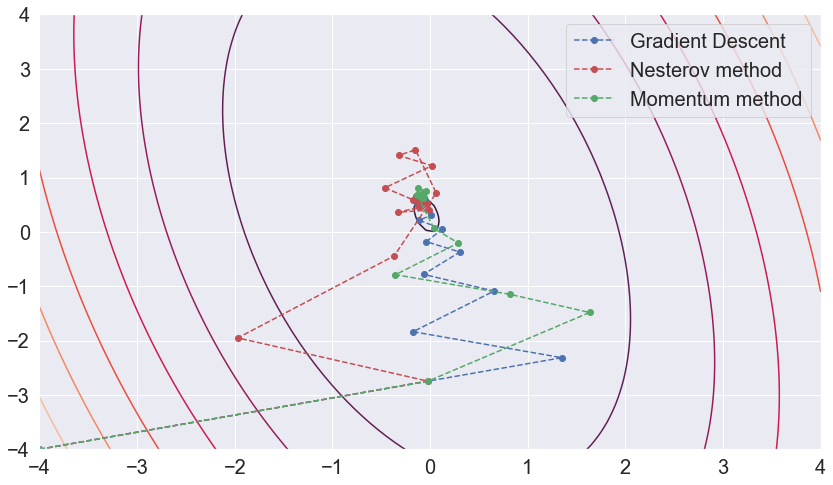

In [14]:
plt.figure(figsize = (14, 8))
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.plot(dots[0][0], dots[0][1], '--bo', label=method_names[0])
plt.plot(dots[1][0], dots[1][1], '--ro', label=method_names[1])
plt.plot(dots[2][0], dots[2][1], '--go', label=method_names[2])
plt.legend(loc="best", fontsize=20)
plt.contour(x, y, f_x)
plt.show()

**Вывод:** метод Момента сходится к оптимуму за меньшеее число итераций по сравнению с другими методами, однако это зависит во многом от значения параметра $\mu$.